<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-09-18' #@param {type:"date"}

In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "19137338" #@param {type:"string"}
Student_full_name = "Rana Das" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

### Explanation of the problem
The intent of this notebook is to correctly classify handwritten samples of numbers from MINST dataset. Classifications of handwritten digits from 0 to 9 from the **MNIST dataset**. The sample contains 10 classes of images of 28x28 pixels each.
 

 
We plan to use two methods. First, General-recipe multinomial **Logistic Regression** and then **Bayesian multinomial regression**.


Logistic regression is easy to implement, interpret, and is very efficient to train. It can easily extend to multiple classes(multinomial regression). Has a good accuracy for many simple data sets and it performs well when the dataset is linearly separable.

Bayesian analyses of multivariate binary or categorical outcomes typically rely on probit or mixed effects logistic regression models that do not have a marginal logistic structure for the individual outcomes.

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a starter database for those who want to try learning techniques and pattern recognition methods on real-world data.

Four files are available on this site:

* train-images-idx3-ubyte.gz:  training set images
* train-labels-idx1-ubyte.gz:  training set labels
* t10k-images-idx3-ubyte.gz:   test set images
* t10k-labels-idx1-ubyte.gz:   test set labels

The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges at various capacities.

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Code

### Library imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [6]:
# Setting a seed:
np.random.seed(123)

## Dataset

#### Note: In this notebook, run locally, the dataset is loaded from current working directory 


### Loading the MNIST dataset

In [7]:
# Path, copy the path from current location/ folder
Path = './'
# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print('Train data Shape', X_train.shape)
# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print('Test data Shape', X_test.shape)

Train data Shape (60000, 784)
Test data Shape (10000, 784)


Note: The MNIST dataset contains 60000 digits for the training sample and 10000 digits for the test samples with 784 (26x28) bytes.

In [8]:
print (X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

Note: We normalize the data to give all features the same range. In this case, we will set the range from 0 to 1 by dividing by 255 ( max pixel value).

In [9]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)

print ('Min Val: ', minv, ', Max Val: ', maxv)

Min Val:  0.0 , Max Val:  1.0


### Description of Data:

In [10]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

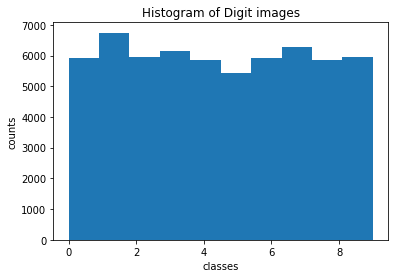

In [11]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [12]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)

# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
print(classes)

[1, 2, 6]


In [13]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000
inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [14]:
print('Train Data:')
print (X_train,y_train)
print('Train Data Shapes:')
print (X_train.shape,y_train.shape)

Train Data:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 6. 6. 6.]
Train Data Shapes:
(15000, 784) (15000,)


New Classes Distribution

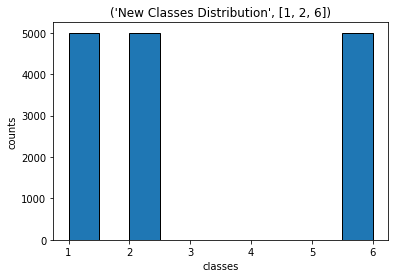

In [15]:
# new histogram
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
title = 'New Classes Distribution', classes
plt.title(title)
plt.show()

In [16]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Show images from each Digit')

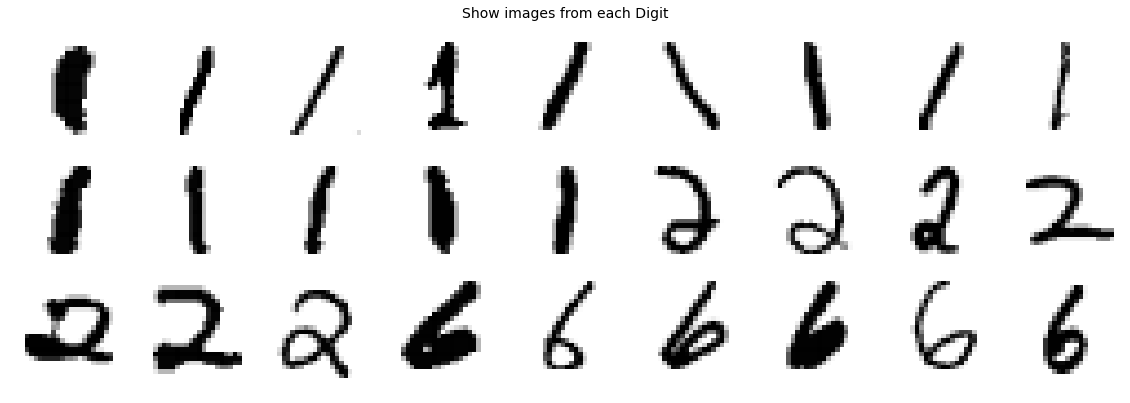

In [17]:
# Show a few instances from each Digit:
plt.figure(figsize=(20,20))
images_per_classes = 9
label_indices = []
# Selecting a few label indices from each of the 3 classes to show:
for i in range(n_classes):
    for i in range(images_per_classes):
        # take index randomly chosen
        label_indices.append(random.randint(0, len(X_train)))
        # choose the image according to the index
        image = X_train[label_indices[i] - 1]

# Sorting the Classes smallest to largest
label_indices.sort()

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=9)
plt.title("Show images from each Digit", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [18]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [19]:
# print shape of your validation and training set


print('Training Set Shape:')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('Validation Set Shape:')
print('X: ', X_val.shape)
print('y: ', y_val.shape)

Training Set Shape:
X: (12000, 784)
y: (12000,)
Validation Set Shape:
X:  (3000, 784)
y:  (3000,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [20]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial')
model_log.fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
# accuracy_score(y_pred_log, y_val)
print('Accuracy Score: ', accuracy_score(y_pred_log, y_val))
print("Misclassifications", len(prob_classmax[y_pred_log!=y_val]),"out of",len(X_val),"instances")

Accuracy Score:  0.974
Misclassifications 78 out of 3000 instances


### Probabilistic Multinomial Logistic Regression:

In [21]:

# General-recipe probabilistic calculation of wrong instances
prob_classmax[y_pred_log!=y_val]
prob_classmax[y_pred_log!=y_val].shape

(78,)

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


## Summary

We analysed MNIST handwritten digit database using two approaches. 

The accuracy was relatively very high. 

## References

## Bibliography

Böhning, D., 1992. Multinomial logistic regression algorithm. Annals of the Institute of Statistical Mathematics, Volume 44, pp. 197-200.

O’Brien, S. M., & Dunson, D. B. (2004). Bayesian Multivariate Logistic Regression. Biometrics, 60(3), 739–746.

LeCun, Y., 2021. MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges. [online] Yann.lecun.com. Available at: <http://yann.lecun.com/exdb/mnist/> [Accessed 19 September 2021].


Koehrsen, W., 2018. Introduction to Bayesian Linear Regression. [Online] Available at: https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7 [Accessed 12 September 2021].
